**Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/climate dataset/GlobalTemperatures.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Overview of Dataset**

In [ ]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,228175.000000,228175.000000
mean,18.125969,0.969343
std,10.024800,0.979644
min,-26.772000,0.040000
25%,12.710000,0.340000
50%,20.428000,0.592000
75%,25.918000,1.320000
max,38.283000,14.037000


In [ ]:
# Get unique city names
unique_cities = df['City'].unique()
print(unique_cities)

['Århus' 'Çorlu' 'Çorum' ... 'Zurich' 'Zuwarah' 'Zwolle']


**Missing Values**

In [ ]:
import pandas as pd

# Checking for missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
print(missing_percentage)

dt                                            0.000000
LandAverageTemperature                        0.375940
LandAverageTemperatureUncertainty             0.375940
LandMaxTemperature                           37.593985
LandMaxTemperatureUncertainty                37.593985
LandMinTemperature                           37.593985
LandMinTemperatureUncertainty                37.593985
LandAndOceanAverageTemperature               37.593985
LandAndOceanAverageTemperatureUncertainty    37.593985
dtype: float64


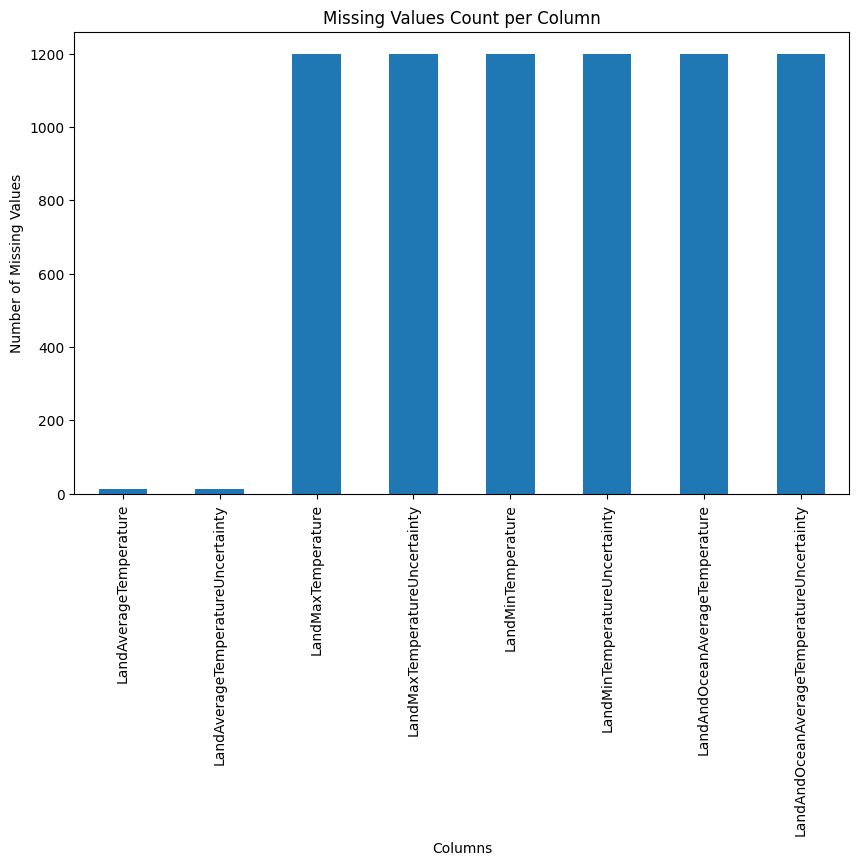

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of missing values in each column
missing_values = df.isnull().sum()

missing_values[missing_values > 0].plot(kind='bar', figsize=(10, 6))
plt.title('Missing Values Count per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.show()


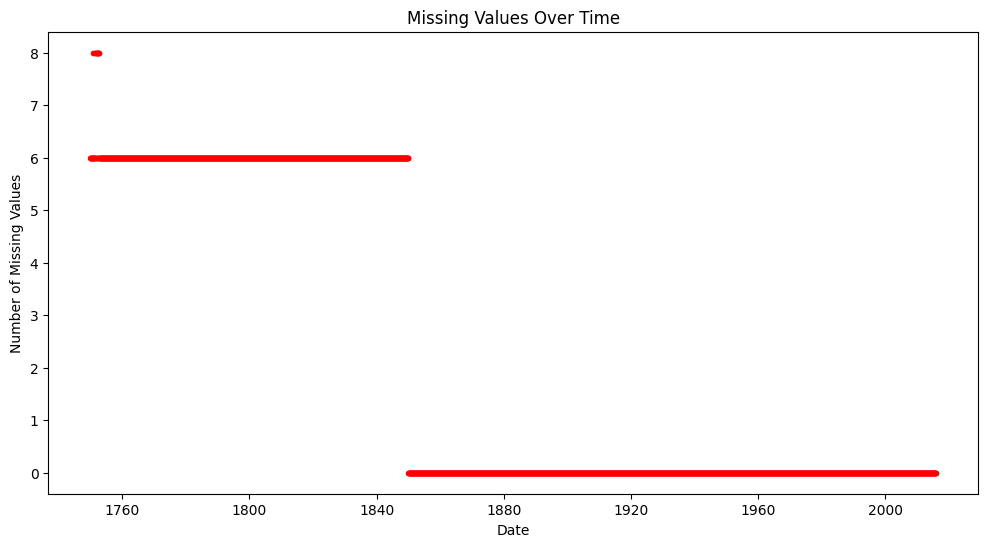

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])

df.set_index('dt', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df.isnull().sum(axis=1), 'r.')
plt.title('Missing Values Over Time')
plt.ylabel('Number of Missing Values')
plt.xlabel('Date')
plt.show()


In [ ]:
missing_values = df.isnull().sum()

total_missing = missing_values.sum()

missing_percentage = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
print(missing_data)

                               Missing Values  Percentage
AverageTemperature                      11002    4.599941
AverageTemperatureUncertainty           11002    4.599941


In [ ]:
num_rows = df.shape[0]
print("Total number of rows:", num_rows)

Total number of rows: 239177


In [ ]:
print("First Row:")
for column, value in df.iloc[0].items():
  print(f"{column}: {value}")

print("\nLast Row:")
for column, value in df.iloc[-1].items():
  print(f"{column}: {value}")


First Row:
dt: 1849-01-01
AverageTemperature: 26.704
AverageTemperatureUncertainty: 1.435
City: Abidjan
Country: Côte D'Ivoire
Latitude: 5.63N
Longitude: 3.23W

Last Row:
dt: 2013-09-01
AverageTemperature: nan
AverageTemperatureUncertainty: nan
City: Xian
Country: China
Latitude: 34.56N
Longitude: 108.97E


In [ ]:
import pandas as pd

# Define two dates in the format 'YYYY-MM-DD'
start = df.iloc[0]['dt']
end = df.iloc[-1]['dt']

print(start)
print(end)

start_date = pd.to_datetime(start)
end_date = pd.to_datetime(end)

duration = end_date - start_date

# Output the duration in days
print(f"{duration.days} days")


1750-01-01
2015-12-01
97123 days


*97123 is 266 years*


---


*266 years is 3192 month*


---


*apparently there is no missing date in this time period*

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
df['Month'] = df['dt'].dt.month
grouped_by_month = df.groupby('Month')

In [ ]:
monthly_data = {}

for month, data in grouped_by_month:
    monthly_data[month] = data

In [ ]:
january_data = monthly_data[0]
print(january_data.head())

           dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
11 1750-12-01                   2.772                              2.970   
23 1751-12-01                     NaN                                NaN   
35 1752-12-01                   5.086                              2.982   
47 1753-12-01                   0.559                              4.174   
59 1754-12-01                   4.587                              3.299   

    LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
11                 NaN                            NaN                 NaN   
23                 NaN                            NaN                 NaN   
35                 NaN                            NaN                 NaN   
47                 NaN                            NaN                 NaN   
59                 NaN                            NaN                 NaN   

    LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
11         

In [ ]:
# Save each month's data to a separate CSV
for month, data in monthly_data.items():
    data.to_csv(f'month_{month}.csv', index=False)

In [ ]:
january_missing = january_data.isnull().sum()
print('January missing value: ')
print(january_missing)

December missing value: 
dt                                             0
LandAverageTemperature                         1
LandAverageTemperatureUncertainty              1
LandMaxTemperature                           100
LandMaxTemperatureUncertainty                100
LandMinTemperature                           100
LandMinTemperatureUncertainty                100
LandAndOceanAverageTemperature               100
LandAndOceanAverageTemperatureUncertainty    100
Month                                          0
dtype: int64


**Handle Missing Values**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [ ]:
df.set_index('dt', inplace=True)

In [ ]:
class LoggingIterativeImputer(IterativeImputer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.imputation_sequence_ = []
        self.iteration_count_ = 0

    def _impute_one_round(self, X_filled, mask_missing_values):
        """Override to add logging after each round."""
        X_filled, predictor_indices, estimator_indices = super()._impute_one_round(
            X_filled, mask_missing_values
        )
        self.iteration_count_ += 1
        print(f"Completed iteration {self.iteration_count_}")
        return X_filled, predictor_indices, estimator_indices

In [ ]:
columns_to_impute = [
    'LandAverageTemperature',
    'LandMaxTemperature',
    'LandMinTemperature',
    'LandAndOceanAverageTemperature',
    'LandAverageTemperatureUncertainty',
    'LandMaxTemperatureUncertainty',
    'LandMinTemperatureUncertainty',
    'LandAndOceanAverageTemperature'
]

In [ ]:
imputer = LoggingIterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0,
    initial_strategy='mean'
)

In [ ]:
data_to_impute = df[columns_to_impute]

# Fit the imputer and transform the data
imputed_array = imputer.fit_transform(data_to_impute)

df_imputed = pd.DataFrame(imputed_array, columns=columns_to_impute, index=data_to_impute.index)

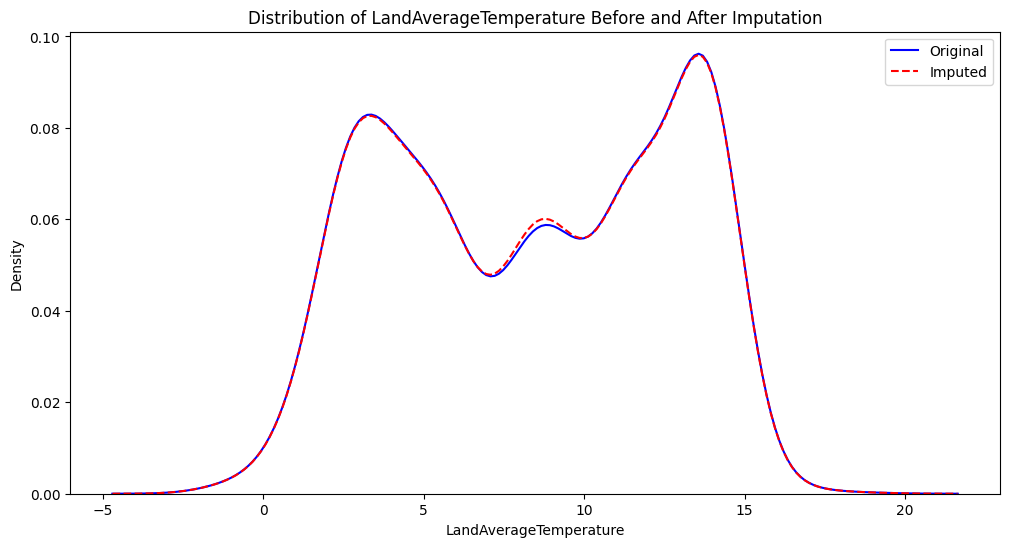

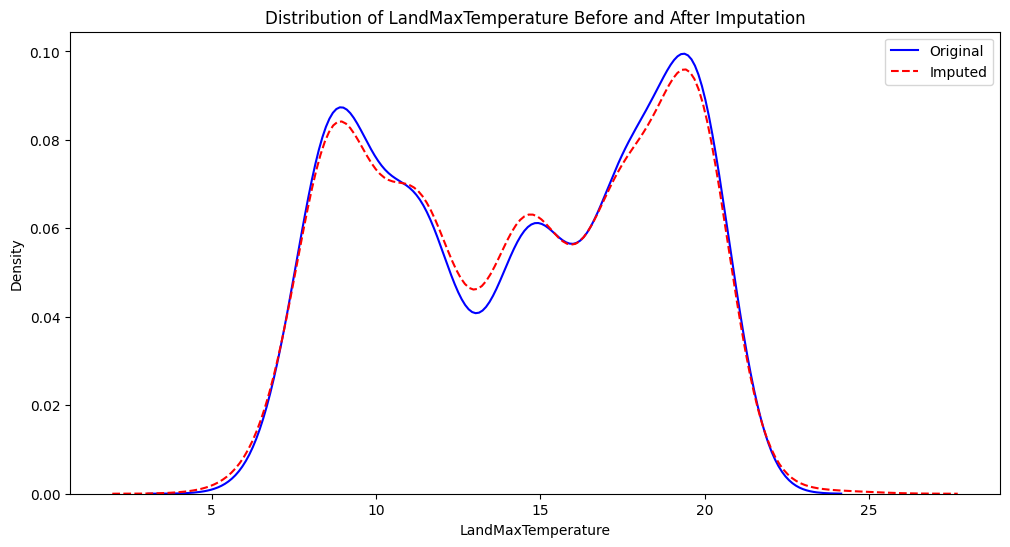

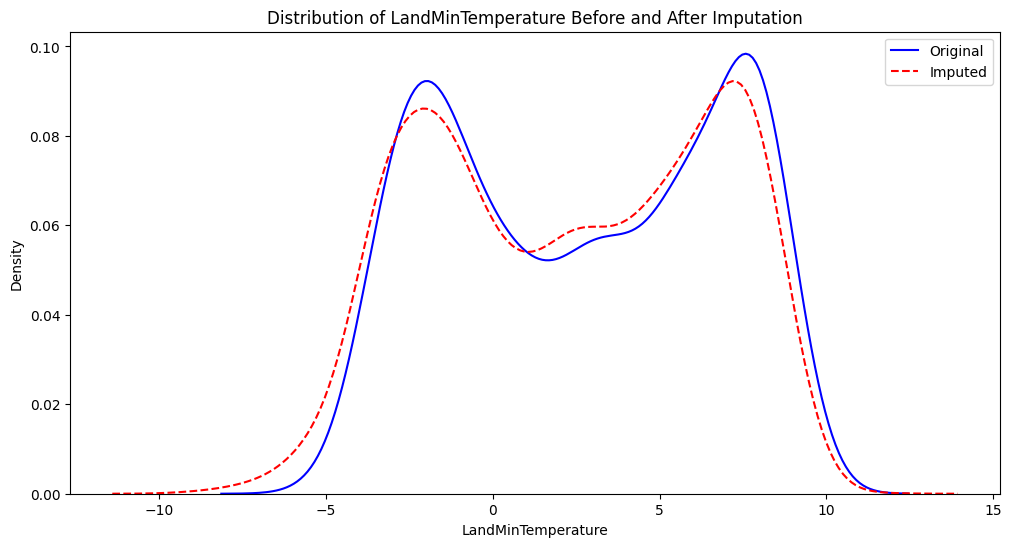

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


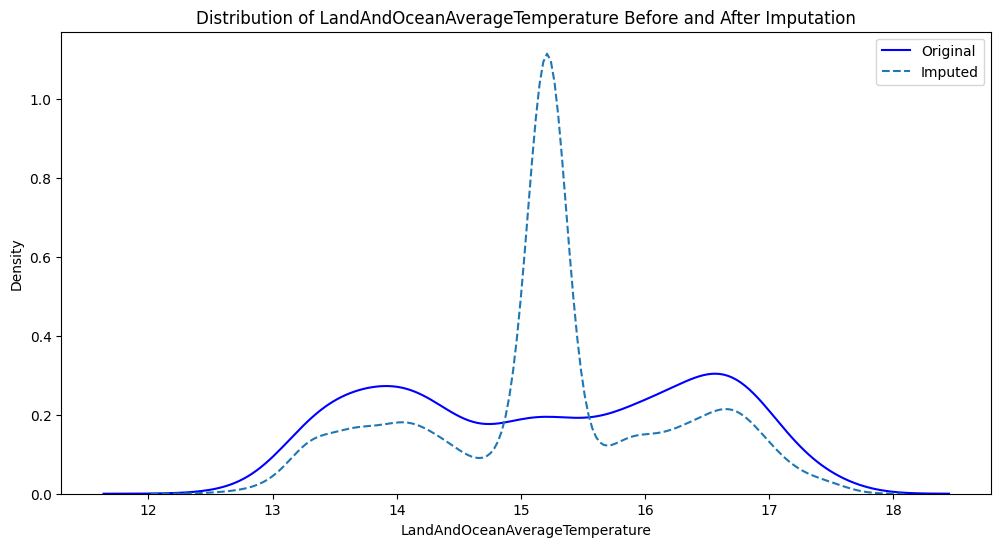

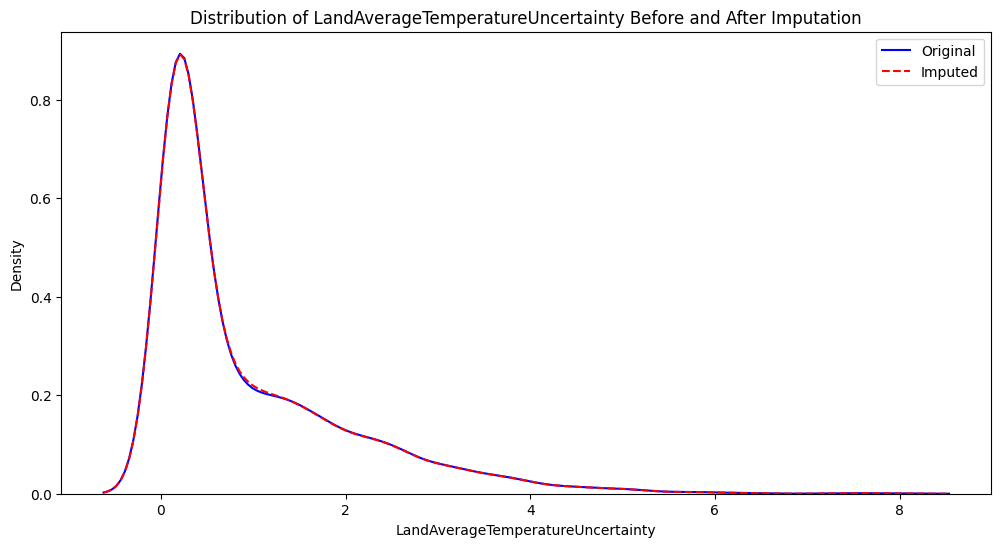

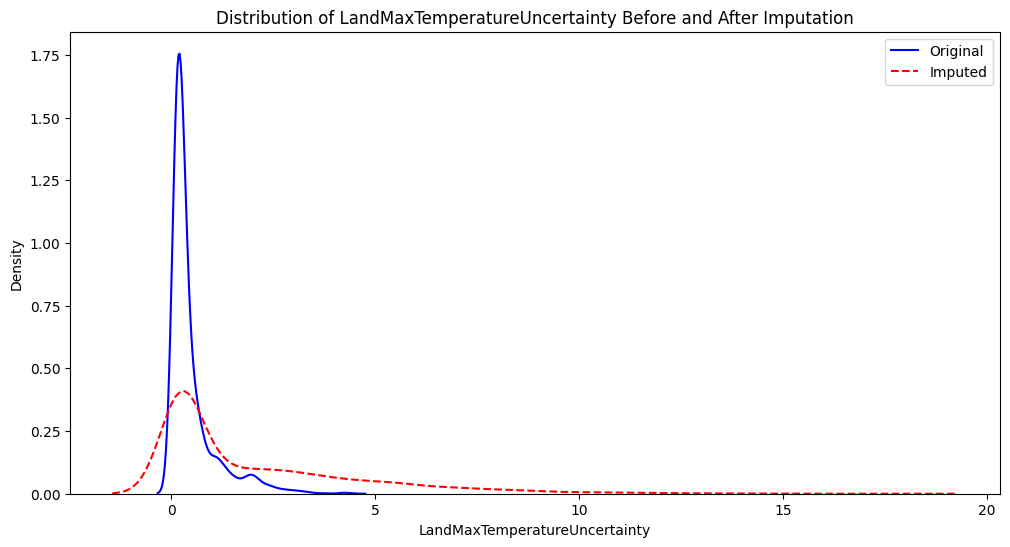

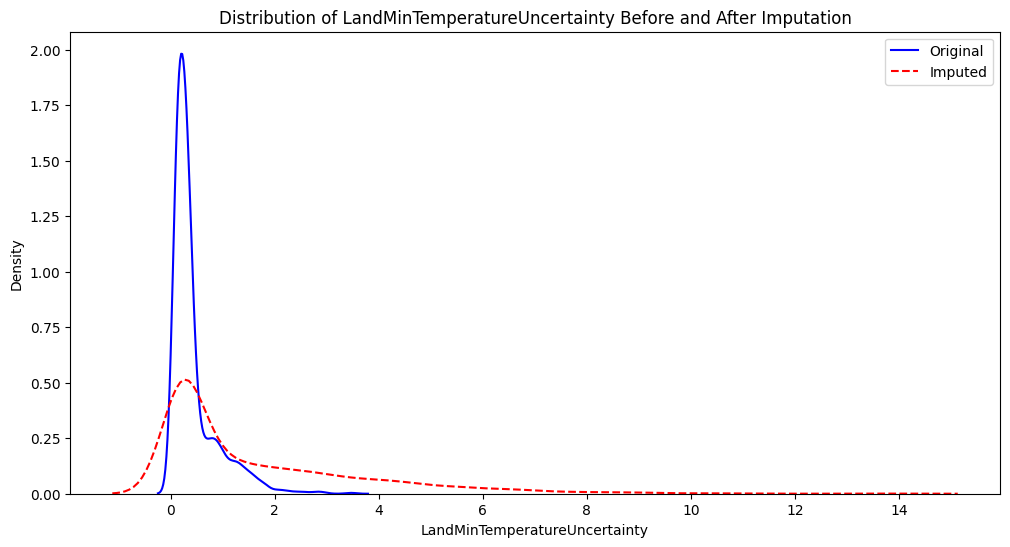

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


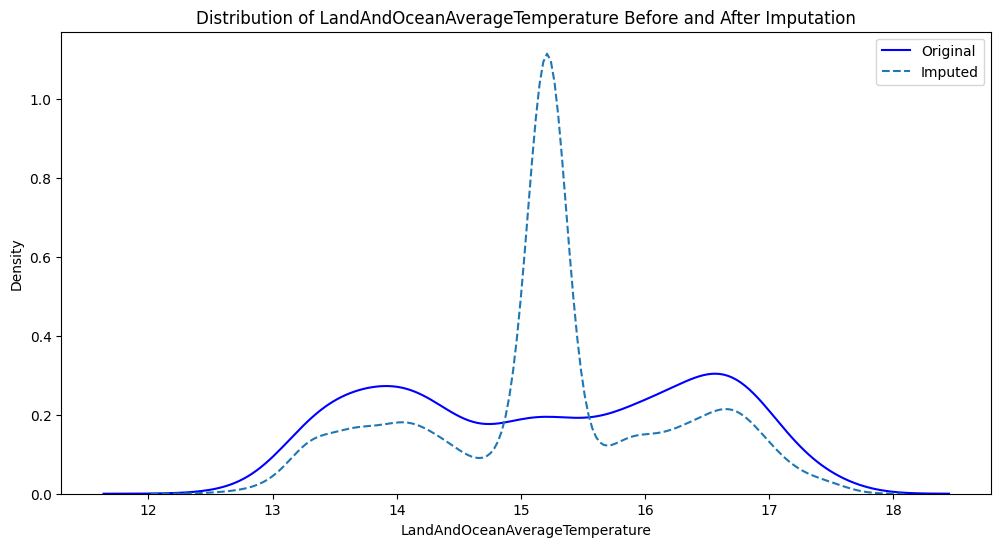

In [ ]:
for column in columns_to_impute:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df[column], label='Original', color='blue')
    sns.kdeplot(df_imputed[column], label='Imputed', color='red', linestyle='--')
    plt.title(f'Distribution of {column} Before and After Imputation')
    plt.legend()
    plt.show()

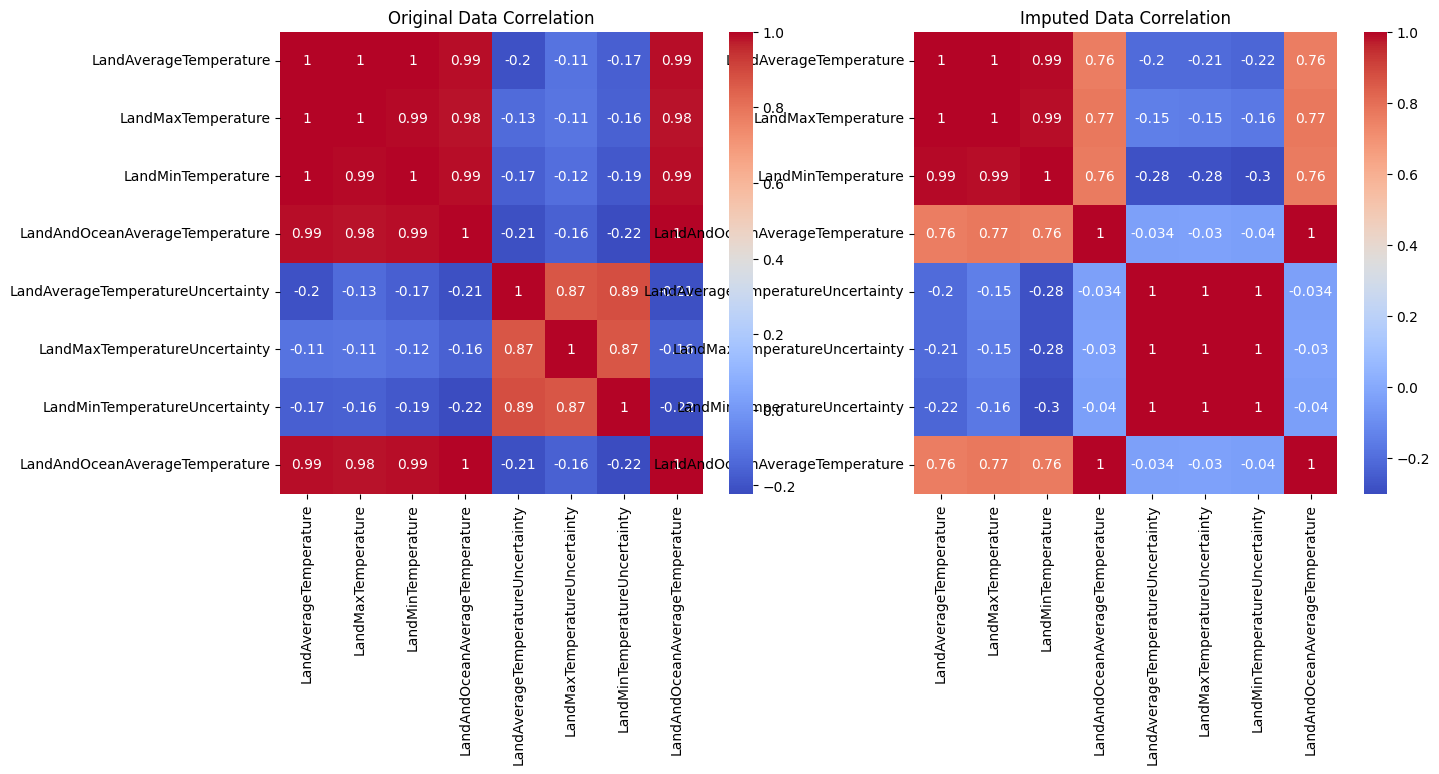

In [ ]:
corr_original = df[columns_to_impute].corr()

corr_imputed = df_imputed.corr()


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(corr_original, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Original Data Correlation')
sns.heatmap(corr_imputed, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Imputed Data Correlation')
plt.show()

In [ ]:
n_imputations = 5
imputed_datasets = []

for i in range(n_imputations):
    imputer = LoggingIterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=i,
        initial_strategy='mean'
    )
    imputed_array = imputer.fit_transform(data_to_impute)
    df_imputed = pd.DataFrame(imputed_array, columns=columns_to_impute, index=data_to_impute.index)
    imputed_datasets.append(df_imputed)

In [ ]:
stacked_data = np.stack([df.values for df in imputed_datasets])

# Compute mean and standard deviation
mean_imputations = np.mean(stacked_data, axis=0)
std_imputations = np.std(stacked_data, axis=0)

mean_df = pd.DataFrame(mean_imputations, columns=columns_to_impute, index=df.index)
std_df = pd.DataFrame(std_imputations, columns=columns_to_impute, index=df.index)

In [ ]:
missing_counts_imputed = df_imputed.isnull().sum()
missing_counts_imputed = missing_counts_imputed[missing_counts_imputed > 0]

if missing_counts_imputed.empty:
    print("No missing values remain after imputation.")
else:
    missing_counts_imputed.plot.bar()
    plt.title('Number of Missing Values per Column After Imputation')
    plt.ylabel('Count of Missing Values')
    plt.show()

No missing values remain after imputation.


In [ ]:
# Save to CSV
df_imputed.to_csv('imputed_climate_data.csv')